In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import matplotlib.colors as mcolors
from tqdm.notebook import tqdm

In [37]:
import clip

In [46]:
clip.__dir__()

['__name__',
 '__doc__',
 '__package__',
 '__loader__',
 '__spec__',
 '__path__',
 '__file__',
 '__cached__',
 '__builtins__',
 'model',
 'simple_tokenizer',
 'clip',
 'available_models',
 'load',
 'tokenize']

In [47]:
clip.__file__

'/home/hkhachatrian/mae/.venv/lib/python3.10/site-packages/clip/__init__.py'

In [36]:
def read_file(path):
    with open(path) as f:
        data = f.readlines()
    return data


def get_start_end(data):
    for i, d in enumerate(data):
        if 'classes' in d:
            start = i
        if 'Score Average' in d:
            end = i
            return start, end
        
        
def get_miou(dataset):
    result = np.zeros(20)
    start, end = get_start_end(dataset)
    i = 0
    for data in dataset[start:end+1]:
        data = data.strip().split(':')
        if len(data) > 1:
            miou = float(data[1].split()[0])
            result[i] = miou
            i += 1

    return result.reshape((1, 20))


def get_classnames(dataset, start, end):
    res = []
    for data in dataset[start:end+1]:
        data = data.strip().split(':')
        if len(data) > 1:
            res.append(data[0].strip())
    return res

In [4]:
'dino_val_cs_patches_256_linear_layer_12.txt'

'dino_val_cs_patches_256_linear_layer_12.txt'

In [31]:
results = []
for model in ['dinov2', 'dino', 'mae', 'sup_vit']:
    degradations = []
    path = f'openseg.pytorch/{model}_val_cs_patches_256_linear_layer_12.txt'
    original = get_miou(read_file(path))
    
    for degradation in ['blur', 'noise', 'frequency_noise']:
        degradation_levels = [original]
        for level in range(1, 5):
            path = f'openseg.pytorch/{model}_val_cs_patches_256_linear_{degradation}_{level}_layer_12.txt'
            data = get_miou(read_file(path))
            degradation_levels.append(data)
            
        degradation_levels = np.concatenate(degradation_levels, axis=0) # shape: [4, 20]
        degradation_levels = degradation_levels.reshape(1, *degradation_levels.shape) # shape: [1, 4, 20]
        degradations.append(degradation_levels)
    degradations = np.concatenate(degradations, axis=0) # shape: [3, 4, 20] 
    degradations = degradations.reshape(1, *degradations.shape) # shape: [1, 3, 4, 20]
    results.append(degradations)
    
results = np.concatenate(results, axis=0) # shape: [4, 3, 4, 20]  models, degradations, degradation_levels, classes



In [32]:
results.shape

(4, 3, 5, 20)

In [ ]:
degradations[0].shape

In [ ]:
results.shape

In [ ]:
results[:, -1]

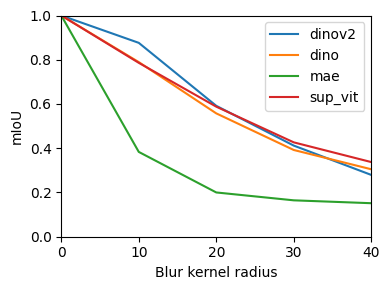

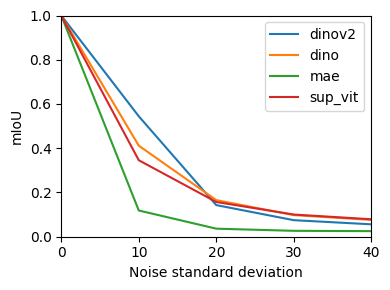

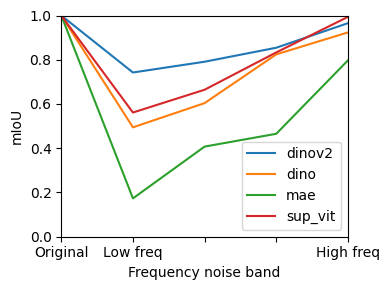

In [34]:
for di, degradation in enumerate(['blur', 'noise', 'frequency_noise']):
    plt.figure(figsize=(4,3))

    for mi, model in enumerate(('dinov2', 'dino', 'mae', 'sup_vit')):
#         plt.plot(results[mi, di, :, -1], label=model)
        plt.plot(results[mi, di, :, -1] / results[mi, di, 0, -1], label=model)
    plt.ylim(0, 1.0)
    plt.xlim(0, 1.0)
    plt.xticks(range(5), 10*np.arange(5))

    if degradation == 'frequency_noise':
        plt.xticks(range(0,5), ['Original', 'Low freq', '', '', 'High freq'])
    else:
        plt.xticks(range(0,5), 10*np.arange(5))
    plt.legend();
    plt.ylabel('Relative robustness (mIoU)')
    plt.ylabel('mIoU')
    if degradation == 'blur':
        plt.xlabel("Blur kernel radius")
    if degradation == 'noise':
        plt.xlabel("Noise standard deviation")
    if degradation == 'frequency_noise':
        plt.xlabel("Frequency noise band")
    plt.tight_layout();